Final padded shape: (1792, 1792, 1)
Patch shape for patchify: (256, 256, 1)
Processing 49 patches for LSTM ViT...
Processing batch 1/13


2025-08-16 10:38:08.562962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


  Processing mask 1/50
  Processing mask 11/50
  Processing mask 21/50
  Processing mask 31/50
  Processing mask 41/50
Processing batch 2/13
  Processing mask 1/50
  Processing mask 11/50
  Processing mask 21/50
  Processing mask 31/50
  Processing mask 41/50
Processing batch 3/13
  Processing mask 1/50
  Processing mask 11/50
  Processing mask 21/50
  Processing mask 31/50
  Processing mask 41/50
Processing batch 4/13
  Processing mask 1/50
  Processing mask 11/50
  Processing mask 21/50
  Processing mask 31/50
  Processing mask 41/50
Processing batch 5/13
  Processing mask 1/50
  Processing mask 11/50
  Processing mask 21/50
  Processing mask 31/50
  Processing mask 41/50
Processing batch 6/13
  Processing mask 1/50
  Processing mask 11/50
  Processing mask 21/50
  Processing mask 31/50
  Processing mask 41/50
Processing batch 7/13
  Processing mask 1/50
  Processing mask 11/50
  Processing mask 21/50
  Processing mask 31/50
  Processing mask 41/50
Processing batch 8/13
  Processing 

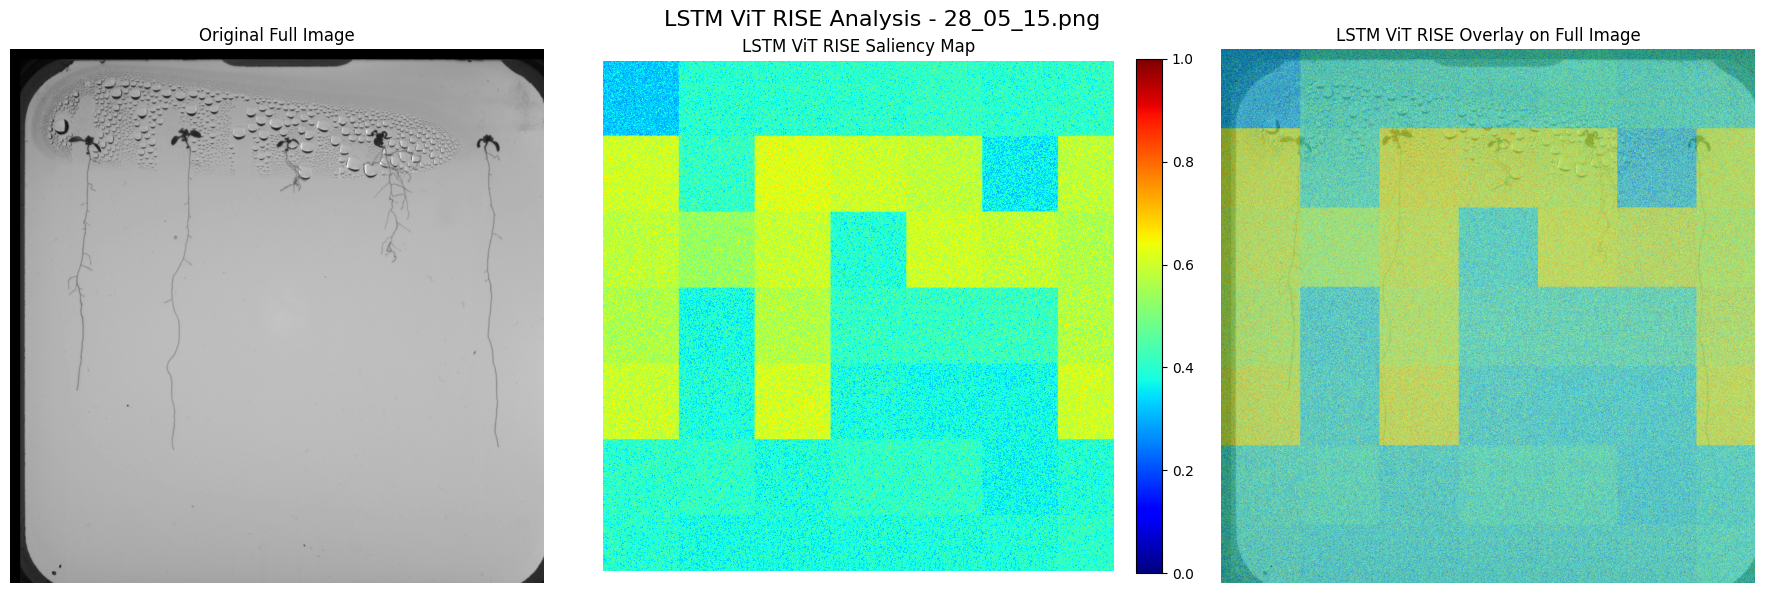

Processing completed.


In [7]:
import cv2
import numpy as np
import pandas as pd
from patchify import patchify, unpatchify
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

from preprocess import crop, padder, crop_to_coordinates
from helpers import f1

def generate_rise_masks(input_shape, n_masks=50, p1=0.5):
    """Generate random binary masks for RISE"""
    masks = []
    for _ in range(n_masks):
        mask = np.random.binomial(1, p1, size=input_shape[:2])
        masks.append(mask)
    return np.array(masks)

def apply_mask(image, mask):
    """Apply binary mask to grayscale image"""
    masked_image = image.copy()
    # For grayscale images with shape (H, W, 1)
    if len(image.shape) == 3 and image.shape[2] == 1:
        masked_image[:, :, 0] = masked_image[:, :, 0] * mask
    else:
        # For 2D grayscale images
        masked_image = masked_image * mask
    return masked_image

def get_rise_saliency_lstm_batch(model, patches, n_masks=50, p1=0.5, batch_size=4):
    """Generate RISE saliency maps for a batch of patches with LSTM UNet"""
    total_patches = len(patches)
    patch_shape = patches[0].shape
    
    # Process in smaller batches to avoid memory issues
    all_saliency_maps = []
    
    for batch_start in range(0, total_patches, batch_size):
        batch_end = min(batch_start + batch_size, total_patches)
        current_patches = patches[batch_start:batch_end]
        current_batch_size = len(current_patches)
        
        print(f"Processing batch {batch_start//batch_size + 1}/{(total_patches + batch_size - 1)//batch_size}")
        
        # Prepare batch for LSTM UNet: (batch, time, height, width, channels)
        # Repeat each patch 15 times for time dimension
        patches_batch = np.array(current_patches)  # Shape: (batch, H, W, C)
        patches_batch = np.repeat(patches_batch[:, np.newaxis, :, :, :], 15, axis=1)  # Shape: (batch, 15, H, W, C)
        
        # Get baseline predictions for current batch
        baseline_preds = model.predict(patches_batch, verbose=0)
        
        # Initialize saliency maps for current batch
        saliency_maps = np.zeros((current_batch_size, patch_shape[0], patch_shape[1]))
        
        # Process each mask
        for mask_idx in range(n_masks):
            if mask_idx % 10 == 0:
                print(f"  Processing mask {mask_idx+1}/{n_masks}")
                
            # Generate single mask for this iteration
            mask = np.random.binomial(1, p1, size=patch_shape[:2])
            
            # Apply mask to current patches
            masked_patches = []
            for patch in current_patches:
                masked_patch = apply_mask(patch, mask)
                masked_patches.append(masked_patch)
            
            # Create batch for masked patches
            masked_patches_batch = np.array(masked_patches)
            masked_patches_batch = np.repeat(masked_patches_batch[:, np.newaxis, :, :, :], 15, axis=1)
            
            # Get predictions for masked patches
            masked_preds = model.predict(masked_patches_batch, verbose=0)
            
            # Calculate differences for each patch in current batch
            for i in range(current_batch_size):
                # Handle different output shapes
                if len(baseline_preds[i].shape) > 1:
                    pred_diff = np.mean(baseline_preds[i]) - np.mean(masked_preds[i])
                else:
                    pred_diff = baseline_preds[i] - masked_preds[i]
                saliency_maps[i] += mask * pred_diff
        
        # Normalize current batch saliency maps
        saliency_maps = saliency_maps / n_masks
        for i in range(current_batch_size):
            smap = saliency_maps[i]
            if smap.max() > smap.min():
                saliency_maps[i] = (smap - smap.min()) / (smap.max() - smap.min())
        
        all_saliency_maps.extend(saliency_maps)
    
    return np.array(all_saliency_maps)

def overlay_saliency_on_image(img, saliency_map, alpha=0.7):
    """Overlay saliency map on grayscale image"""
    # Convert grayscale to RGB for visualization
    if len(img.shape) == 3 and img.shape[2] == 1:
        img_rgb = np.repeat(img, 3, axis=2)
    elif len(img.shape) == 2:
        img_rgb = np.stack([img, img, img], axis=2)
    else:
        img_rgb = img
    
    saliency_rgb = plt.cm.jet(saliency_map)[:, :, :3]
    overlay = saliency_rgb * alpha + img_rgb * (1 - alpha)
    return overlay

def pipeline_lstm(image_dir, kernel_size=5, patch_size=256, n_masks=50, p1=0.5):
    # Load LSTM UNet model
    model_path = "lstm_vit_model.h5"  # Adjust path as needed
    model = load_model(model_path, custom_objects={"f1": f1})

    for file in os.listdir(image_dir):
        if file.endswith('28_05_15.png'):
            
            # Load and preprocess image
            img_path = os.path.join(image_dir, file)
            image = cv2.imread(img_path, 0)  # Keep as grayscale
            image_cropped, stats, centroids = crop(image, kernel_size=kernel_size)
            
            # Keep as grayscale and normalize
            image_np = image_cropped / 255.0
            
            # Add channel dimension for grayscale
            if len(image_np.shape) == 2:
                image_np = np.expand_dims(image_np, axis=-1)  # Shape: (H, W, 1)

            # Pad and patchify - more robust approach
            image_padded = padder(image_np, patch_size=patch_size)
            
            # Handle different shapes returned by padder
            if len(image_padded.shape) == 2:
                # If padder returns 2D, add channel dimension
                image_padded = np.expand_dims(image_padded, axis=-1)
                patch_shape = (patch_size, patch_size, 1)
            elif len(image_padded.shape) == 3:
                # If padder keeps 3D shape
                patch_shape = (patch_size, patch_size, image_padded.shape[2])
            else:
                raise ValueError(f"Unexpected image shape after padding: {image_padded.shape}")
            
            print(f"Final padded shape: {image_padded.shape}")
            print(f"Patch shape for patchify: {patch_shape}")
            
            # Now patchify with the correct dimensions
            patches = patchify(image_padded, patch_shape, step=patch_size)
            expected_shape = (image_padded.shape[0] // patch_size, image_padded.shape[1] // patch_size)
            
            # Reshape based on the actual patch shape
            if len(patch_shape) == 3:
                patches = patches.reshape(-1, patch_size, patch_size, patch_shape[2])
            else:
                patches = patches.reshape(-1, patch_size, patch_size)
            
            print(f"Processing {len(patches)} patches for LSTM ViT...")
            
            # Apply RISE to all patches in batch using LSTM-specific function
            saliency_maps = get_rise_saliency_lstm_batch(model, patches, n_masks=n_masks, p1=p1)
            
            # Generate overlay patches
            overlay_patches = []
            for i, patch in enumerate(patches):
                overlay_patch = overlay_saliency_on_image(patch, saliency_maps[i])
                overlay_patches.append(overlay_patch)
            
            # Reshape patches back to grid format using the expected_shape
            # Fix: Keep patches as grayscale for reconstruction
            patches_grid = np.array(patches).reshape(
                expected_shape[0], expected_shape[1], 
                patch_size, patch_size, 1  # Keep as 1 channel
            )
            
            saliency_patches_grid = np.array(saliency_maps).reshape(
                expected_shape[0], expected_shape[1], 
                patch_size, patch_size
            )
            
            overlay_patches_grid = np.array(overlay_patches).reshape(
                expected_shape[0], expected_shape[1], 
                patch_size, patch_size, 3
            )
            
            # Manual reconstruction
            grid_h, grid_w = expected_shape[0], expected_shape[1]
            
            # Initialize full arrays with correct shapes
            full_image_reconstructed = np.zeros(image_padded.shape)  # Grayscale shape
            full_saliency_reconstructed = np.zeros(image_padded.shape[:2])
            full_overlay_reconstructed = np.zeros((*image_padded.shape[:2], 3))  # RGB for overlay
            
            # Manually place each patch back
            for i in range(grid_h):
                for j in range(grid_w):
                    y_start = i * patch_size
                    y_end = y_start + patch_size
                    x_start = j * patch_size
                    x_end = x_start + patch_size
                    
                    # Place patches back
                    full_image_reconstructed[y_start:y_end, x_start:x_end] = patches_grid[i, j]
                    full_saliency_reconstructed[y_start:y_end, x_start:x_end] = saliency_patches_grid[i, j]
                    full_overlay_reconstructed[y_start:y_end, x_start:x_end] = overlay_patches_grid[i, j]
            
            # Crop back to original size (remove padding)
            original_h, original_w = image_np.shape[:2]
            full_image_final = full_image_reconstructed[:original_h, :original_w]
            full_saliency_final = full_saliency_reconstructed[:original_h, :original_w]
            full_overlay_final = full_overlay_reconstructed[:original_h, :original_w]
            
            # Plot the full reconstructed results
            fig, axs = plt.subplots(1, 3, figsize=(18, 6))
            
            # Original full image (convert to 2D for display)
            if len(full_image_final.shape) == 3:
                axs[0].imshow(full_image_final.squeeze(), cmap='gray')
            else:
                axs[0].imshow(full_image_final, cmap='gray')
            axs[0].set_title("Original Full Image")
            axs[0].axis("off")
            
            # Saliency map
            im1 = axs[1].imshow(full_saliency_final, cmap='jet')
            axs[1].set_title("LSTM ViT RISE Saliency Map")
            axs[1].axis("off")
            plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
            
            # Overlay
            axs[2].imshow(full_overlay_final)
            axs[2].set_title("LSTM ViT RISE Overlay on Full Image")
            axs[2].axis("off")
            
            plt.suptitle(f"LSTM ViT RISE Analysis - {file}", fontsize=16)
            plt.tight_layout()
            plt.show()

    print("Processing completed.")

pipeline_lstm('data_v3_processed/xai', kernel_size=5, patch_size=256, n_masks=50, p1=0.8)